In [1]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [0]:
using Pkg

pkg"add CuArrays"
pkg"add Flux"
pkg"add ImageMagick"
pkg"add Images"
pkg"add Plots"

pkg"precompile"

using Base.Iterators: partition

using CuArrays
using Flux
using Flux: @epochs, mse, throttle
using Flux.Data.MNIST
using Images

using LinearAlgebra
using Random
using Statistics

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed Requires ─────────── v0.5.2
 Installed Adapt ────────────── v1.0.0
 Installed CUDAapi ──────────── v2.0.0
 Installed GPUArrays ────────── v2.0.0
 Installed AbstractFFTs ─────── v0.4.1
 Installed MacroTools ───────── v0.5.2
 Installed DataStructures ───── v0.17.6
 Installed CuArrays ─────────── v1.4.7
 Installed TimerOutputs ─────── v0.5.3
 Installed CEnum ────────────── v0.2.0
 Installed OrderedCollections ─ v1.1.0
 Installed NNlib ────────────── v0.6.0
 Installed LLVM ─────────────── v1.3.2
 Installed CUDAnative ───────── v2.5.5
 Installed CUDAdrv ──────────── v4.0.4
  Updating `~/.julia/environments/v1.0/Project.toml`
  [3a865a2d] + CuArrays v1.4.7
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [621f4979] + AbstractFFTs v0.4.1
  [79e6a3ab] + Adapt v1.0.0
  [fa961155] + CEnum v0.2.0
  [3895d2a7] + CUDAapi v2.0.0
  

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1192


Precompiling CuArrays


┌ Info: Precompiling CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1192


Precompiling Flux


┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1192


Precompiling ImageMagick


┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1192


Precompiling Plots


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


# Autoencoders #

And now, a completely different loss function!

## Intermission: Minor organisational matters ##

Tomorrow (Friday) will be my last office hours for the term as I am going on parental leave the next week. As students at UCL you are of course welcome to use my office hours in the future, but keep this in mind if you want to meet regarding projects.

Upcoming lectures:

* November 21st: Autoencoders (today)
* November 25th: A concrete realisation of a recurrent neural network
* November 26th: Convolutional neural networks
* November 27th: Attention
* November 28th: A concrete realisation of a convolutional neural network
* December 3rd: From reinforcement learning to deep reinforcement learning (Minqi JIANG)
* December 10th: Bayesian deep learning (David BARBER)
* December ???? (timetabling…): Neural methods for knowledge graphs (Pasquale MINERVINI)

Do not trust your timetable, note that some one-hour lectures are “missing”… Also, stay tuned for the rehearsal later on.

Upcoming tutorials:

* November 25th
* December 2nd
* December 9th

I am considering *trying* to organise during the first week in January, but more on that later.


## “Vanilla” autoencoder ##

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

[Image source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

$$ f(\textbf{x}) = \textbf{x}^{\prime} $$

$$ \textbf{x} \in \mathbb{R}^d $$

$$ \textbf{x}^{\prime} \in \mathbb{R}^d $$

$$ \textbf{z} \in \mathbb{R}^{d^{\prime}} $$

$$ d^{\prime} < d $$

Why is this important?

As seen in the illustration above, it is common to split $f$ into two separate components:

$$ f_{\textrm{enc}}(\textbf{x}) = \textbf{z} $$

$$ f_{\textrm{dec}}(\textbf{z}) = \textbf{x}^{\prime} $$

Note that there are no labels, only inputs, thus we can easily formulate an unsupervised “reconstruction loss”:

$$\mathcal{L}(x, x^{\prime}) = \frac{\sum_{\textbf{x}_i \in X} \left\Vert \textbf{x}_i - \textbf{x}_{i}^{\prime} \right\Vert^2}{|X|} $$


## Input as output ##

So, wait… You are telling me that our goal is to get our input back. What possible use is such a function?

Yes, this is true. In its initial formulation this may all seem like a useless exercise. But most of the time we care very little for $x^{\prime}$, rather, we are interested in $z$ – the “code”.

Imagine for example that we set the dimensionality $2$, well, we now have a dimensionality reduction technique where our model will learn a latent code $z$ that best allows it to reconstruct the complexity of its input.

![](http://sqlml.azurewebsites.net/wp-content/uploads/2018/08/null-12.png)

[Image source](http://sqlml.azurewebsites.net/category/artificial-intelligence/machine-learning/)

What else could one use an autoencoder for?

## A concrete implementation ##

In [0]:
using Flux: onehotbatch

function load(set; sub=1)
    images = MNIST.images(set)[1:div(end, sub)]
    labels = MNIST.labels(set)[1:div(end, sub)]
    # Brownie points, what do you think this does…?
    xs = hcat(float.(reshape.(images, :))...) |> gpu
    ys = onehotbatch(labels, 0:9) |> gpu
    (images, labels, xs, ys)
end

trainimages, trainlabels, trainxs, trainys = load(:train, sub=10)
@show size(trainxs) trainxs[:, 1] size(trainys) trainys[:, 1]
validimages, validlabels, validxs, validys = load(:valid, sub=10)
testimages, testlabels, testxs, testys = load(:test, sub=10)

nothing

size(trainxs) = (784, 6000)


┌ Info: Building the CUDAnative run-time library for your sm_37 device, this might take a while...
└ @ CUDAnative /root/.julia/packages/CUDAnative/2WQzk/src/compiler/rtlib.jl:188


trainxs[:, 1] = Gray{Float32}[Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float32}(0.0), Gray{Float

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /root/.julia/packages/GPUArrays/0lvhc/src/indexing.jl:16


trainys[:, 1] = Bool[false, false, false, false, false, true, false, false, false, false]


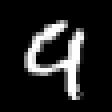

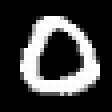

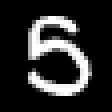

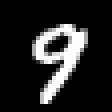

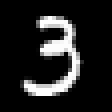

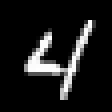

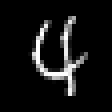

In [0]:
for _ in 1:7
    display(trainimages[rand(1:end)])
end

In [0]:
xs  = gpu.([float(hcat(vec.(imgs)...)) for imgs in partition(trainimages, 2048)])
vxs = gpu.([float(hcat(vec.(imgs)...)) for imgs in partition(validimages, 2048)])

# Code size (yes, it is a hyperparameter…)
zsize = 32

encoder = Dense(28^2, zsize, sigmoid)
decoder = Dense(zsize, 28^2, sigmoid)
m       = Chain(encoder, decoder) |> gpu
loss(x) = mse(m(x), x)
opt     = ADAM()

nothing

In [0]:
@time for epoch in 1:512
    Flux.train!(loss, params(m), zip(xs), opt)
    println("$(epoch)\t$(loss(xs[1]))\t$(loss(vxs[1]))")
    flush(stdout)
end

1	0.035578992f0 (tracked)	0.036237147f0 (tracked)
2	0.03557357f0 (tracked)	0.036231957f0 (tracked)
3	0.035568148f0 (tracked)	0.036226787f0 (tracked)
4	0.035562728f0 (tracked)	0.036221597f0 (tracked)
5	0.035557315f0 (tracked)	0.036216427f0 (tracked)
6	0.035551913f0 (tracked)	0.036211256f0 (tracked)
7	0.035546504f0 (tracked)	0.036206096f0 (tracked)
8	0.035541106f0 (tracked)	0.036200933f0 (tracked)
9	0.035535708f0 (tracked)	0.036195766f0 (tracked)
10	0.03553031f0 (tracked)	0.036190614f0 (tracked)
11	0.035524916f0 (tracked)	0.036185462f0 (tracked)
12	0.035519537f0 (tracked)	0.036180317f0 (tracked)
13	0.035514157f0 (tracked)	0.036175165f0 (tracked)
14	0.035508774f0 (tracked)	0.036170024f0 (tracked)
15	0.035503395f0 (tracked)	0.036164895f0 (tracked)
16	0.035498027f0 (tracked)	0.036159758f0 (tracked)
17	0.03549266f0 (tracked)	0.036154635f0 (tracked)
18	0.035487294f0 (tracked)	0.036149506f0 (tracked)
19	0.035481937f0 (tracked)	0.03614438f0 (tracked)
20	0.035476588f0 (tracked)	0.036139265f0 (tr

In [0]:
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

function reconstruct(imgs)
  before = [imgs[i] for i in rand(1:length(imgs), 32)]
  after  = img.(map(x -> cpu(m)(float(vec(x))).data, before))
  hcat(vcat.(before, after)...)
end

nothing

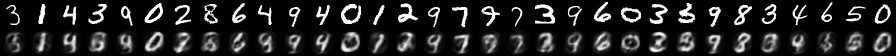

In [0]:
reconstruct(trainimages)

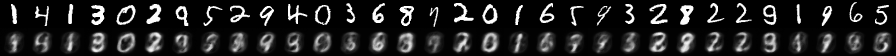

In [0]:
reconstruct(validimages)